# Test of "filter" and "filtfilt" Functions from Ardour

| Resources | Links |
| --- | --- |
| Ardour open source code:        | https://github.com/djpohly/ardour/tree/master/libs/qm-dsp/dsp/signalconditioning |
| MATLAB filtfilt function info:  | https://de.mathworks.com/help/signal/ref/filtfilt.html |
| MATLAB filtfilt source code:    | type "open filtfilt" in MATLAB command window...  |
| SciPy filfilt open source code: |https://github.com/scipy/scipy/blob/master/scipy/signal/signaltools.py |

### Import Packages and load Data Set

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# data path for matlab data
data_path = os.path.join( os.getcwd(), 'data', 'matlab_sine_data_highNoise.CSV')
filter_path = os.path.join( os.getcwd(), 'data', 'matlab_sine_filter_highNoise.CSV')

# load matlab results as pandas Dataframe
df_matlab_results = pd.read_csv(data_path, sep=';')
df_filter = pd.read_csv(filter_path, sep=';')

In [3]:
df_index = df_matlab_results.index.values.flatten()                 # index of dataframe entries (0 - 1001)
df_wform = df_matlab_results.wform.values.flatten()                 # base signal: ECG-Waveform without noise
df_wform_noisy = df_matlab_results.wform_noisy.values.flatten()     # input signal for analysis: ECG-Waveform with noise
df_matlab_filtfilt = df_matlab_results.y_filtfilt.values.flatten()  # MATLAB "filtfilt" function results for input signal
df_matlab_filter = df_matlab_results.y_filter.values.flatten()      # MATLAB "filter" function results for input signal

df_num_filt = df_filter.num_filt.values.flatten()  # numerator (B) of used filter (butterworth filter, order: 9)
df_den_filt = df_filter.den_filt.values.flatten()  # denominator (A) of used filter (butterworth filter, order: 9)

### Plot used Data 

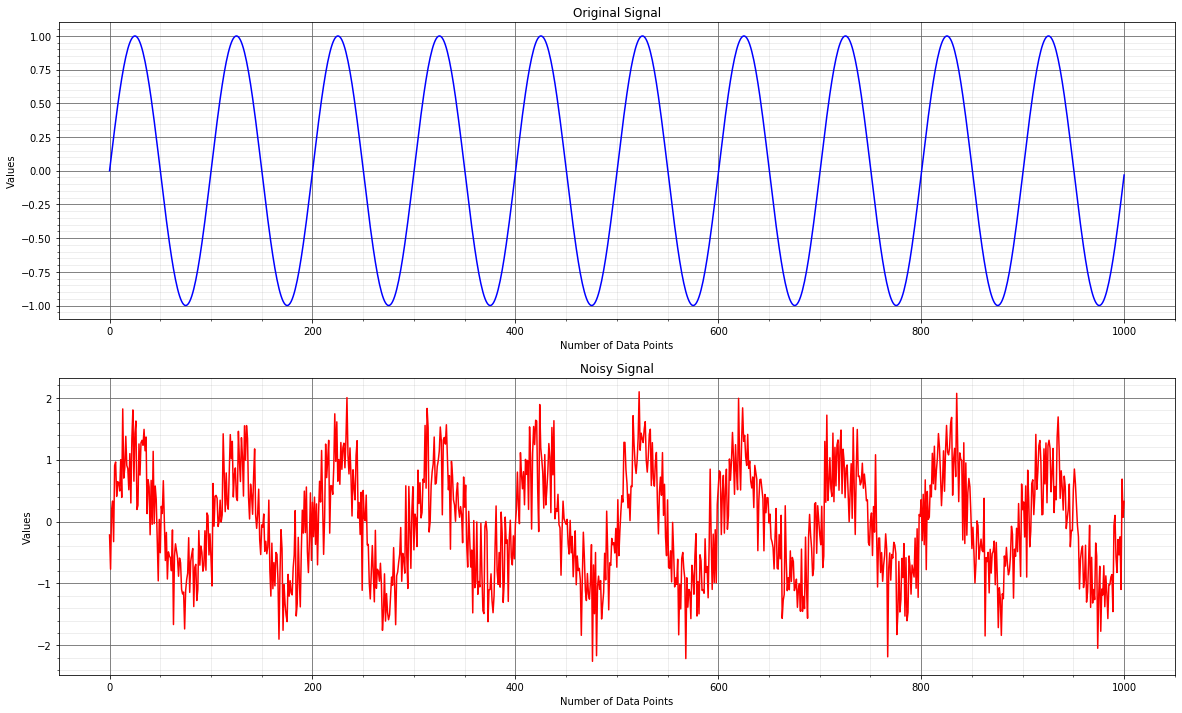

In [4]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,12))

ax0.plot(df_index, df_wform, color='blue', label ='orginal signal')
ax1.plot(df_index, df_wform_noisy, color='red', label ='noisy signal')

ax0.set_title('Original Signal')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Noisy Signal')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

## Ardour "filter" Function (conventional filter with phase-distortion)

In [5]:
def filterArdour(filt_ord, filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    u = input_signal                # input signal
    length = input_signal_len       # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))         # output signal; initialize with zeros
    
    inBuffer = np.zeros((filt_ord+1,))  # buffer for input signal with window length of (filter_ord+1) ; initialize with zeros
    outBuffer = np.zeros((filt_ord+1,)) # buffer for output signal with window length of (filter_ord+1) ; initialize with zeros
    
    for j in range(0, length):

        # move input buffer and sample value of input signal (required for feedforward path of IIR-Filter)
        for i in range(0, filt_ord):
            inBuffer[filt_ord-i] = inBuffer[filt_ord-i-1]
        inBuffer[0] = u[j]   # sample input signal of current time step

        # reset output value for current time step
        y_temp = 0

        # calculate feedforward path (B of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp + filt_BCoeffs[i] * inBuffer[i]

        # calculate feedback path (A of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp - filt_ACoeffs[i+1] * outBuffer[i]

        # write calculated filter output of current time step into output array
        y[j] = y_temp

        # move output buffer and sample value of output signal (required for feedback path of IIR-Filter)
        for i in range(0, filt_ord-1):
            outBuffer[filt_ord-i-1] = outBuffer[filt_ord-i-2]
        outBuffer[0] = y_temp
    
    return y;


### Test of "filter" Function

In [6]:
y_filterArdour = filterArdour(
    filt_ord = 9, 
    filt_ACoeffs = df_den_filt, 
    filt_BCoeffs = df_num_filt, 
    input_signal = df_wform_noisy, 
    input_signal_len = 1001)

# calculate error between MATLAB filter function and Ardour filter function
filter_error = np.abs(df_matlab_filter - y_filterArdour)

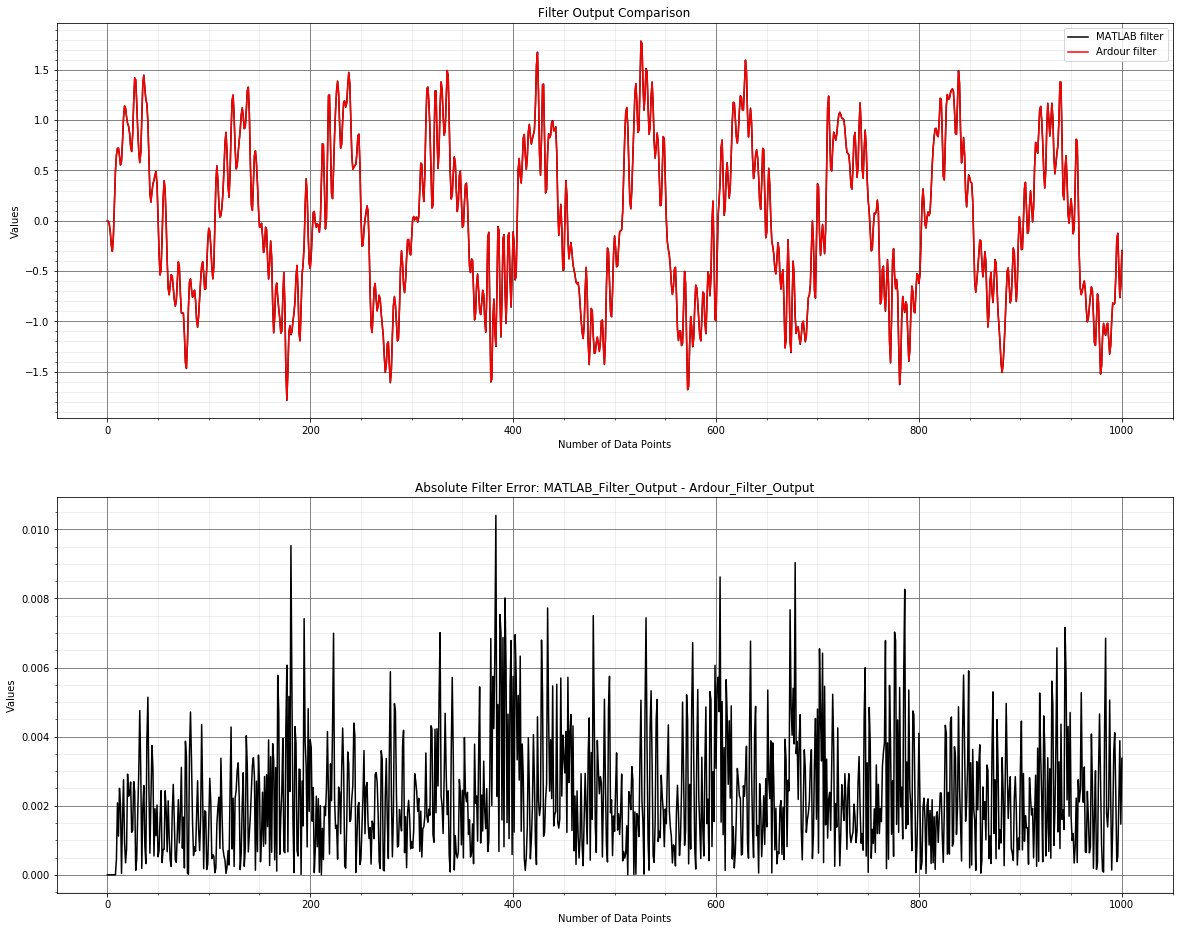

In [7]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filter, color='black', label ='MATLAB filter')
ax0.plot(df_matlab_results.index, y_filterArdour, color='red', label ='Ardour filter')
ax1.plot(df_matlab_results.index, filter_error, color='black', label ='Filter Error')

ax0.set_title('Filter Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute Filter Error: MATLAB_Filter_Output - Ardour_Filter_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

## Ardour "filtfilt" Function (conventional filter with phase-distortion)

In [8]:
def filtfiltArdour(filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Variable initilization and preprocessing
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    u = input_signal            # input signal
    length = input_signal_len   # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))     # output signal; initialize with zeros
    
    filtACoeffs = filt_ACoeffs  # filter numerator coefficients
    filtBCoeffs = filt_BCoeffs  # filter denominator coefficients

    na = len(filtACoeffs)       # number of filter feedback coefficients (A)
    nb = len(filtBCoeffs)       # number of filter feedforward coefficients (B)
    nFilt = max(na,nb)          # max. number of given filter coefficients 
    filtOrd = nFilt - 1         # filter order
    nFact = 3 * ( nFilt - 1)    # length of edge transients ( 3 times filter order)
    nExt = length + 2 * nFact   # padding before and after signal
    
    nfilt = max(na,nb)          # 
    nfact = max(1,3*(nfilt-1))  # length of edge transients
    
    sample0 = 2*u[0]            # used for edge transfer reflection
    sampleN = 2*u[length-1]     # used for edge transfer reflection
    index = 0;                  # index variable for loops
    filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
    filtScratchOut = np.zeros((nExt,)) # function intern output sequence
    
    # zero pad shorter coeff arrays as needed
    if (nb < nFilt):
        filtBCoeffs = np.zeros((nFilt,))
    elif (na < nFilt):
        filtACoeffs = np.zeros((nFilt,))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Edge Transfer Reflection
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   starting edge transfer reflection
    for i in range(nFact, 0, -1):
        filtScratchIn[index] = sample0 - u[i]
        index = index + 1
        
    #   ending edge transfer reflection
    index = 0;
    for i in range(0, nFact):
        filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
        index = index + 1
        
    # (normal/unedited) raw signal inbetween edge transfer padding
    for i in range(0, length):
        filtScratchIn[i + nFact] = u[i]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 1st filtering (forward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                            filt_ACoeffs = filtACoeffs, 
                            filt_BCoeffs = filtBCoeffs, 
                            input_signal = filtScratchIn, 
                            input_signal_len = nExt)    
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 2nd filtering (backward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   reverse the filtered signal:
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    #   filter the reversed signal again (backward filtering)
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                        filt_ACoeffs = filtACoeffs, 
                        filt_BCoeffs = filtBCoeffs, 
                        input_signal = filtScratchIn, 
                        input_signal_len = nExt)
    
    #   reverse the reversed signal again to get the normal signal
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Remove Edge Transients padding for Output Signal
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range(0, length):
        y[i] = filtScratchIn[i + nFact]
        
    return y

In [9]:
y_filtfiltArdour = filtfiltArdour(
                            filt_ACoeffs = df_den_filt, 
                            filt_BCoeffs = df_num_filt, 
                            input_signal = df_wform_noisy, 
                            input_signal_len = 1001)  

# calculate error between MATLAB filtfilt function and Ardour filtfilt function
filtfilt_error = np.abs(df_matlab_filtfilt - y_filtfiltArdour)

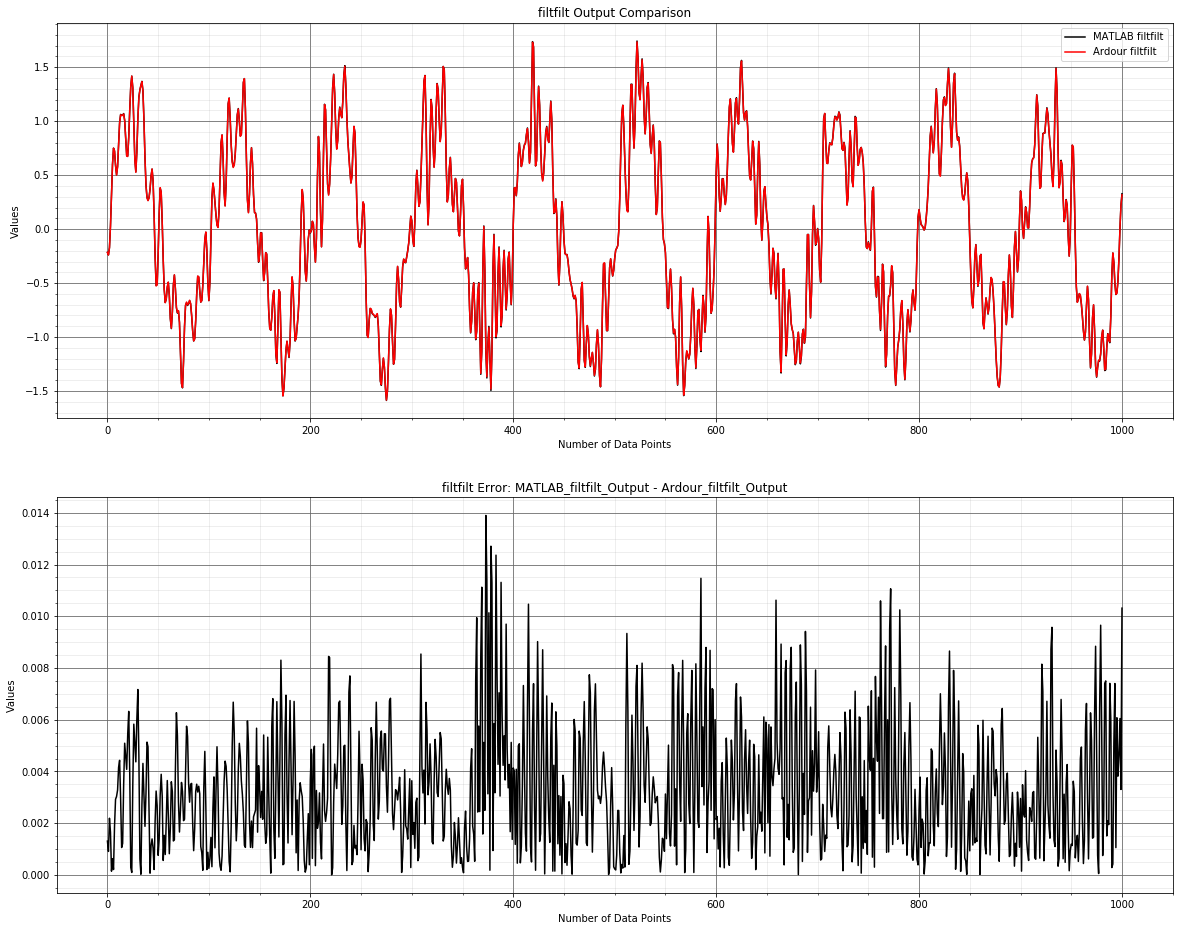

In [10]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filtfilt, color='black', label ='MATLAB filtfilt')
ax0.plot(df_matlab_results.index, y_filtfiltArdour, color='red', label ='Ardour filtfilt')
ax1.plot(df_matlab_results.index, filtfilt_error, color='black', label ='filtfilt error')

ax0.set_title('filtfilt Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('filtfilt Error: MATLAB_filtfilt_Output - Ardour_filtfilt_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# Comparison between "filter" and "filtfilt" (Ardour)

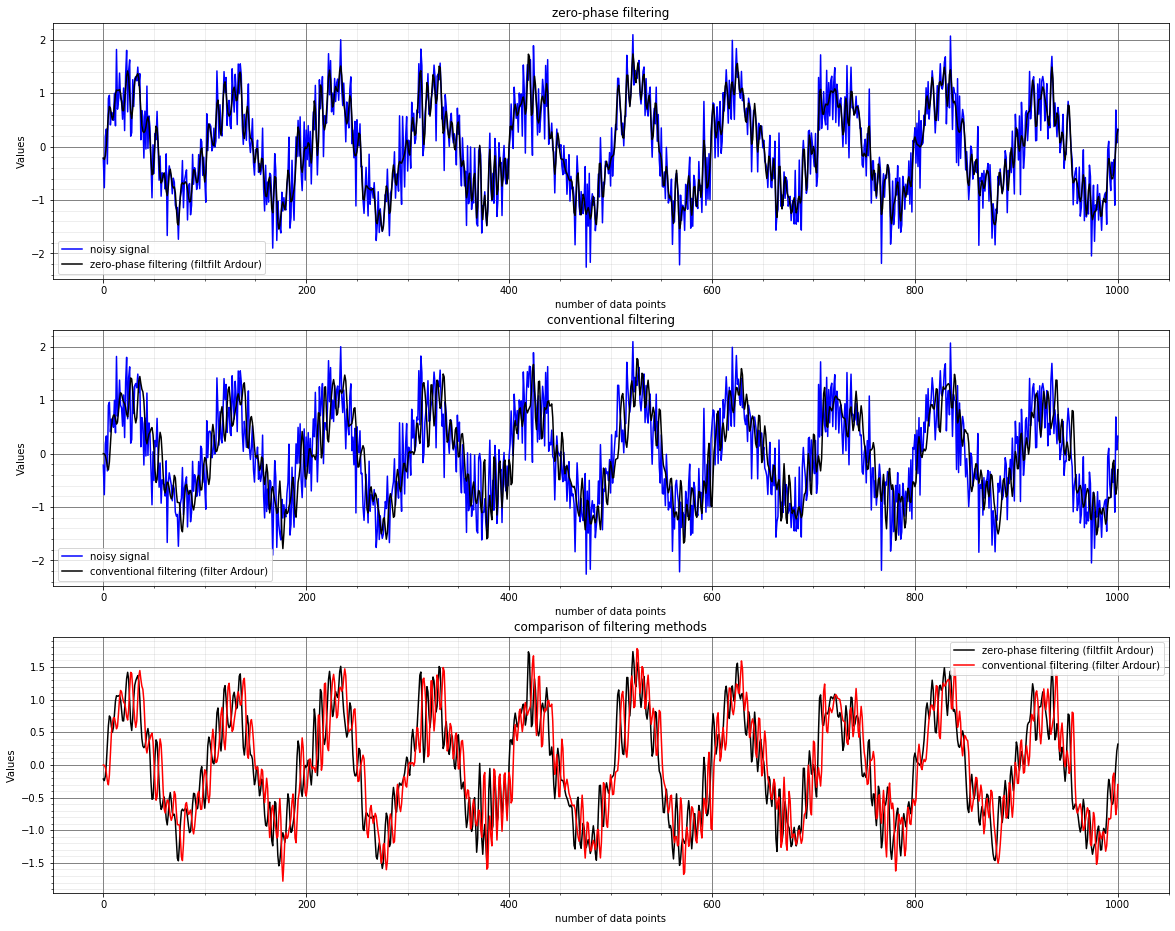

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_wform_noisy, color='blue', label ='noisy signal')
ax0.plot(df_matlab_results.index, y_filtfiltArdour, color='black', label ='zero-phase filtering (filtfilt Ardour)')
ax1.plot(df_matlab_results.index, df_wform_noisy, color='blue', label ='noisy signal')
ax1.plot(df_matlab_results.index, y_filterArdour, color='black', label ='conventional filtering (filter Ardour)')
ax2.plot(df_matlab_results.index, y_filtfiltArdour, color='black', label ='zero-phase filtering (filtfilt Ardour)')
ax2.plot(df_matlab_results.index, y_filterArdour, color='red', label ='conventional filtering (filter Ardour)')

ax0.set_title('zero-phase filtering')
ax0.set_xlabel('number of data points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('conventional filtering')
ax1.set_xlabel('number of data points')
ax1.set_ylabel('Values')
ax1.legend()
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax2.set_title('comparison of filtering methods')
ax2.set_xlabel('number of data points')
ax2.set_ylabel('Values')
ax2.legend()
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();